## Jupyter Notebook:
check a few things: how to save (Ctrl+S), how to run a code block (Caps+Enter),how to move (arrows), how to create a cell (find it yourself ! : browse the menus a bit before starting !).
Note: in jupyter, like in ipython, if you just write a variable name at the end of your code (or running cell), its value will be displayed (you do not need to write "print(myVariable)", it's enough to write "myVariable")

In [1]:
from platform import python_version
python_version()

'3.6.8'

In [2]:
python_version()
print(python_version()) #does the same as above
"some string with some value, typed into the last line of the cell"

3.6.8


'some string with some value, typed into the last line of the cell'

In [3]:
print(python_version()) #does the same as above
python_version()

3.6.8


'3.6.8'

In [4]:
# ### this is useful only if you unfortunately run suing python2. If you run python3, these lines are effect-less.
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Goal of the tutorial:

The aim of this tutorial is to implement the Naive Bayesian calssifier on the MNIST image data set. (optionally, also on the 20newsgroups text data set).

Let's begin with MNIST. It's in the GDrive, and may be accessed "locally" at: 
https://www.lri.fr/~flandes/share/ 
    
MNIST contains images (observations, inputs) of single hand-written digits and the corresponding classes (labels, Ground Truth). 
So it is a 10-classes classification problem (0 to 9).


## Loading the data

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
from ipywidgets import FloatProgress
from IPython.display import display

# ## Load the dataset -- (python2)
# import cPickle, gzip
# with gzip.open('./tp1-mnist.pkl.gz','rb') as f :
#     train_set, valid_set, test_set = cPickle.load(f)

### Load the dataset -- (python3)
import pickle, gzip
with gzip.open('./mnist.pkl.gz','rb') as f :
    u = pickle._Unpickler( f )
    u.encoding = 'latin1'
    train_set, valid_set, test_set = u.load()

NLABELS=10
print(str(len(train_set[0]))+" training examples")
# exemple: 
im    = train_set[0][0] # the first image
label = train_set[1][0] # its label

50000 training examples


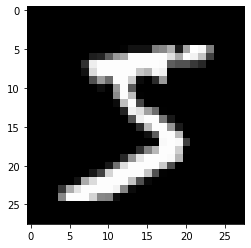

In [5]:
plt.imshow(im.reshape(28,28) , matplotlib.pyplot.cm.gray)    
# plt.contourf(im.reshape(28,28))

## Content of data

Images are stored as numpy arrays, where each line is an image, i.e. a 784-rows vector (28x28=784). Each pixel encodes a Grey value between 0 and 1.
* What do train_set, valid_set, test_set contain ? (size, type, ... )
* Write a function binarize_image(image, threshold) with a default threshold=0.5 to project an image onto binary pixels (black&white intead of grey levels)
* Try various thresholds and look for differences.

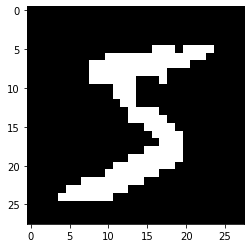

In [6]:
## train set contains train images and train labels
## same thing for valid and test set

def binarize_image(image, threshold=0.5):
    binarized_image = image.copy() ## make a deep copy (not necessary but more clear to read)
    binarized_image = np.array((image > threshold), dtype=int) ## "dtype=int" allows to cast the bool into ints
    return binarized_image
## we test it on one image:
just_1_image_for_test = binarize_image(train_set[0][0], 0.3)
plt.imshow(just_1_image_for_test.reshape(28,28) , matplotlib.pyplot.cm.gray)    


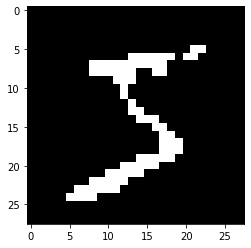

In [7]:
just_1_image_for_test = binarize_image(train_set[0][0], 0.8)
plt.imshow(just_1_image_for_test.reshape(28,28) , matplotlib.pyplot.cm.gray)    


## Getting to know the data
Here are a few examples

In [8]:
# getting images and their labels
images = train_set[0]
labels = train_set[1]
images_test = test_set[0]
labels_test = test_set[1]
print("shape d'images  :"+str(images.shape))
print("shape de labels :"+str(labels.shape))
# values
print("val. max  ", images.max())
print("val. min  ", images.min())
print("val. mean ", images.mean())
print("val. var  ", images.var())

# how many images represent the digit "5" ?
print("number of images of which the digit shwon is a 5 :"+str((labels==5).sum()))
# labels==5 returns an ndarray of same dimensionality as labels but filled with booleans.
# if the label is 5, True (1), else, False (0).
# On peut se servir de cet ndarray pour faire du slicing de images
fives = (images[labels==5])
print("fives contains all images of which the label is 5, there number is:"+str(fives.shape))


shape d'images  :(50000, 784)
shape de labels :(50000,)
val. max   0.99609375
val. min   0.0
val. mean  0.13044983
val. var   0.094427034
number of images of which the digit shwon is a 5 :4506
fives contains all images of which the label is 5, there number is:(4506, 784)


## Naive Bayesian (model chosen: Bernoulli)
Observations (images) are initially continuous. We need to project these data onto the space accessible to our model. In the case of Bernoulli, each pixel can only be 0 or 1 (intermediate values cannot be sampled from a Bernoulli law).

### pre-processing (of the data -what else?)

- Apply the thresholding operation to all *train* and *test* data. (it may take ~O(1) minute: try your function on test images, they are fewer)
- Check it on a couple of images.


In [9]:
# binarized training-set images
bin_train_imgs = binarize_image(train_set[0][:], 0.3)
# binarized testing-set images
bin_test_imgs = binarize_image(test_set[0][:], 0.3)
## note: we called the same function binarize_image with arguments that are 
## either just 1 image   (train_set[0][0])
## or all images at once (train_set[0][:]) !!
## And in both cases it worked. This is the magic of python :) 

In [10]:
print(bin_train_imgs.shape)
bin_train_imgs

(50000, 784)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Implementing the Naive Bayesian, Bernoulli

To implement this classifier, there are only two steps:
- estimating parameters $\theta$ (including the prior probability for each class).
- inference itself:
    - knowing the parameters, return the posterior probability of classes
    - (for each image) infer the class (given the model, and this image' data)


To-do list:
Before coding, **pen and paper** !
- Which are the parameters $\theta$? Define them precisely.
- Write down the exact equations for each step; ideally, down to the pixel level.

If you don't know how to start, start with the end: write down the probability P(y|X) (see your lecture notes)


Now that **you know exactly what you want**, write down the functions needed.

Check them at several stages: 
- represent the parameters as images or graphs, (choose adequately)
- check your prediction on a couple of examples (not just 1 !!)

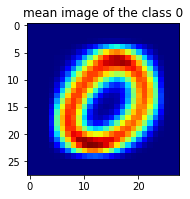

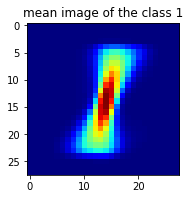

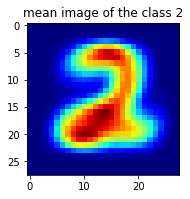

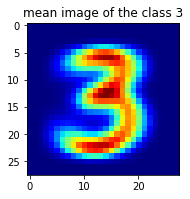

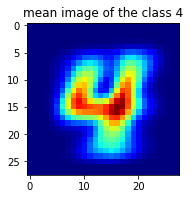

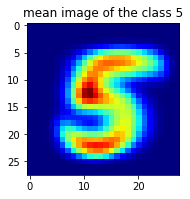

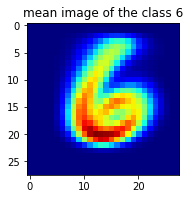

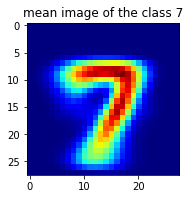

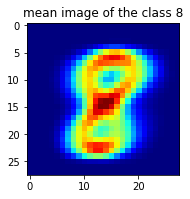

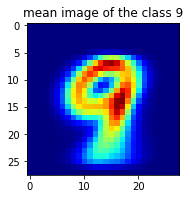

In [11]:
## extract the parameters (those associated to each class, which are essentially "representatives")
D = 28*28
K = NLABELS
pkj = np.zeros((K, D))
for k in range(K):
    training_sub_set = bin_train_imgs[labels==k]# get the subpart of train for the class
    pkj[k] = training_sub_set.mean(axis=0)    # compute the average rate 

    # plot pkj[k][:], the Bernoulli parameters, as an image, for each class
    fig = plt.figure()
    a=fig.add_subplot(1,2,1)
    plt.imshow(pkj[k].reshape(28,28) , matplotlib.pyplot.cm.jet)  
    a.set_title('mean image of the class '+str(k))
    matplotlib.pyplot.show()

In [13]:
## compute the priors (for each class)
priors = np.zeros((K))
for k in range(K):
    priors[k]=labels[labels==k].shape[0]
priors = priors/priors.sum()
print(priors)

[0.09864 0.11356 0.09936 0.10202 0.09718 0.09012 0.09902 0.1035  0.09684
 0.09976]


In [16]:
## make a function that computes the posterior, for a given image
# trick: when computing log(p), one should type log(1+EPSILON), to avoid float overflow errors (when p~0)
def computePosteriors(image, EPSILON=1e-6):  ## 1e-100 seems too little !!
    posteriors = np.zeros([NLABELS])
    for k in range(NLABELS):
        p = pkj[k]  # average image of label k (array of length 784)
        logp1 = np.log(p+EPSILON)
        logp2 = np.log(1-p+EPSILON)
        ## Log-LikelyHood = LLH : log(pi_k) + log( P(xi|k,theta) )  (+regularization)
        llh = np.dot(image,logp1)+np.dot(1-image,logp2) # im*log(average_Im + EPS) + (1-im)*log(1-average_IM+EPS)
        post = llh + np.log(priors[k])   ## we add  log(prior)  to account for the inner distribution of classes 
        posteriors[k]= post
    return posteriors
posts=computePosteriors(bin_train_imgs[0])   
print("posterior probabilities for each class:\n", posts,"\n Predicted label for this image:",np.argmax(posts))
print("(log) posterior value for that class: ", np.max(posts) )

posterior probabilities for each class:
 [-283.39445548 -342.00155442 -272.25952734 -208.11067187 -308.95356779
 -203.56240081 -380.47159191 -286.98886682 -226.62634931 -292.4021646 ] 
 Predicted label for this image: 5
(log) posterior value for that class:  -203.5624008106717


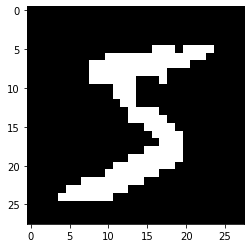

In [17]:
just_1_image_for_test = binarize_image(bin_train_imgs[0], 0.8)
plt.imshow(just_1_image_for_test.reshape(28,28) , matplotlib.pyplot.cm.gray)

### [option 1: apply your function to all the train/test data]

In [20]:
from timeit import default_timer as timer

In [21]:
## this is slow !! ##
def makePrediction(images):
    N = images.shape[0]
    posteriors = np.zeros((N,K))
    predictions = np.zeros(N, dtype=int)
    for i in range(N):
        posteriors[i] = computePosteriors(images[i], EPSILON=1e-5)
        predictions[i] = np.argmax(posteriors[i]) ## one-liner. See the help page of: np.argmax()
    return predictions

# start = timeit.timeit()
# prediction_train = makePrediction(bin_train_imgs)
# end = timeit.timeit()
# print(end - start, " seconds (training set)")

start = timer()
prediction_test = makePrediction(bin_test_imgs)
end = timer()
print(end - start, " seconds (test set)")

2.3672902  seconds (test set)


In [19]:
prediction_test, labels_test

(array([7, 2, 1, ..., 9, 8, 6]), array([7, 2, 1, ..., 4, 5, 6]))

In [22]:
prediction_test[:40], labels_test[:40], (prediction_test!=labels_test)[:40]*1

(array([7, 2, 1, 0, 4, 1, 4, 9, 4, 9, 0, 6, 9, 0, 1, 3, 9, 7, 3, 4, 9, 6,
        4, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 0, 7, 2, 7, 1, 3, 1]),
 array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6,
        6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]))

(10000,)

In [26]:
np.sum((prediction_test==labels_test)*1)/prediction_test.shape[0]*100

84.38

In [23]:
prediction_test, labels_test

(array([7, 2, 1, ..., 9, 8, 6]), array([7, 2, 1, ..., 4, 5, 6]))

### [option 2: re-write your function in a more pythonic way, handling all images at once]

In [26]:
##[option 2]: much more pythonic: array-wise computation 
##(much much faster)
def computePosteriorsAllImages(image, EPSILON=1e-5):
    Nexamples = image.shape[0] 
    ## we handle the special case of doing just 1 image at a time :
    if len(image.shape) == 1:
        Nexamples = 1
    
    # the main difference is here: in the shape of the array "posteriors": we add 1 dimension
    posteriors = np.zeros([NLABELS, Nexamples])
    
    for k in range(NLABELS):
        p = pkj[k]  
        logp1 = np.log(p+EPSILON)
        logp2 = np.log(1-p+EPSILON)
        llh = np.dot(image,logp1)+np.dot(1-image,logp2) # im*log(average_Im + EPS) + (1-im)*log(1-average_IM+EPS)
        post = llh + np.log(priors[k])   ## we add  log(prior)  to account for the inner distribution of classes 
        
        ## this is the second difference with the 1st version: we have to write the result 
        ## into the k-th component of the array
        posteriors[k]= post.copy()
    return posteriors
    
posteriorsAllImages = computePosteriorsAllImages(images)

In [27]:
def makePrediction(images):
    predictions = np.argmax(computePosteriorsAllImages(images), axis=0)
    return predictions

start = timer()
predictions_train = makePrediction(images)
end = timer()
print(end - start, " seconds (training set)")

start = timer()
predictions_test = makePrediction(images_test)
end = timer()
print(end - start, " seconds (test set)")

3.59964203835  seconds (training set)
0.69525384903  seconds (test set)


array([7, 2, 1, ..., 9, 5, 6])

# NOTE: 

you can see that the full-numpy-version (no loop, except on classes, just 10 iteration) is about ~100x faster !

note: 

at this point, you should have two arrays, *prediction_test_data* and *prediction_train*

## evaluation of the quality of the classifier
evaluate the classifier on the test data:
- compute the error rate
- show the confusion matrix


In [28]:
def compute_confusion_matrix(dataset, groundTruthLabels ):
    tot=0.0
    correct=0.0
    confusion = np.zeros([NLABELS,NLABELS])
    for i in range(dataset.shape[0]):
        posts = computePosteriors(dataset[i],1e-100)
        prediction=np.argmax(posts)
        if prediction==groundTruthLabels[i]:
            correct+=1
        confusion[prediction][groundTruthLabels[i]]+=1
        tot+=1
        if (tot%1000==0):
            print("OK : "+str(correct)+" / "+str(tot)+ " -> "+ str(correct*100/tot)+"%"  )
    print("OK : "+str(correct)+" / "+str(tot)+ " -> "+ str(correct*100/tot)+"%")  
    return confusion

test_set_conf_mat = compute_confusion_matrix(bin_test_imgs, labels_test)

OK : 821.0 / 1000.0 -> 82.1%
OK : 1601.0 / 2000.0 -> 80.05%
OK : 2406.0 / 3000.0 -> 80.2%
OK : 3213.0 / 4000.0 -> 80.325%
OK : 4007.0 / 5000.0 -> 80.14%
OK : 4893.0 / 6000.0 -> 81.55%
OK : 5771.0 / 7000.0 -> 82.4428571429%
OK : 6652.0 / 8000.0 -> 83.15%
OK : 7593.0 / 9000.0 -> 84.3666666667%
OK : 8443.0 / 10000.0 -> 84.43%
OK : 8443.0 / 10000.0 -> 84.43%


In [29]:
## long to compute, and kind of useless 
## (could be much faster to compute if we used  computePosteriorsAllImages() )
train_set_conf_mat = compute_confusion_matrix(bin_train_imgs, labels)

OK : 842.0 / 1000.0 -> 84.2%
OK : 1670.0 / 2000.0 -> 83.5%
OK : 2517.0 / 3000.0 -> 83.9%
OK : 3377.0 / 4000.0 -> 84.425%
OK : 4234.0 / 5000.0 -> 84.68%
OK : 5083.0 / 6000.0 -> 84.7166666667%
OK : 5933.0 / 7000.0 -> 84.7571428571%
OK : 6751.0 / 8000.0 -> 84.3875%
OK : 7574.0 / 9000.0 -> 84.1555555556%
OK : 8427.0 / 10000.0 -> 84.27%
OK : 9287.0 / 11000.0 -> 84.4272727273%
OK : 10112.0 / 12000.0 -> 84.2666666667%
OK : 10935.0 / 13000.0 -> 84.1153846154%
OK : 11758.0 / 14000.0 -> 83.9857142857%
OK : 12550.0 / 15000.0 -> 83.6666666667%
OK : 13383.0 / 16000.0 -> 83.64375%
OK : 14213.0 / 17000.0 -> 83.6058823529%
OK : 15027.0 / 18000.0 -> 83.4833333333%
OK : 15899.0 / 19000.0 -> 83.6789473684%
OK : 16739.0 / 20000.0 -> 83.695%
OK : 17563.0 / 21000.0 -> 83.6333333333%
OK : 18420.0 / 22000.0 -> 83.7272727273%
OK : 19236.0 / 23000.0 -> 83.6347826087%
OK : 20073.0 / 24000.0 -> 83.6375%
OK : 20877.0 / 25000.0 -> 83.508%
OK : 21718.0 / 26000.0 -> 83.5307692308%
OK : 22552.0 / 27000.0 -> 83.5259259

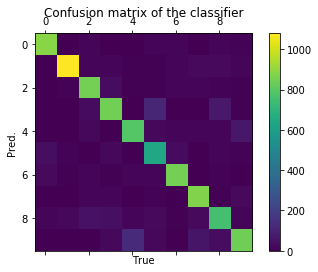

array([[ 889,    0,   17,    2,    2,   19,   15,    1,   13,   11],
       [   0, 1079,   13,   15,    6,    8,   17,   28,   26,   16],
       [   3,   11,  855,   34,    7,    6,   16,   15,   12,    5],
       [   3,    4,   30,  850,    0,  115,    1,    4,   72,    8],
       [   1,    0,   22,    0,  793,   24,   16,   16,   17,   70],
       [  40,    9,    4,   22,    3,  642,   31,    1,   20,    9],
       [  27,    6,   21,    8,   19,   20,  855,    0,   11,    1],
       [   1,    1,   15,   14,    2,    9,    0,  874,    5,   26],
       [  16,   25,   52,   43,   18,   27,    7,   27,  761,   18],
       [   0,    0,    3,   22,  132,   22,    0,   62,   37,  845]])

In [30]:
#confusion = np.zeros((10,10))
#confusion = np.log(test_set_conf_mat)
confusion = test_set_conf_mat
## showing the confusion matrix with a color map ("heat map")
import pylab as pl
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion)
pl.title('Confusion matrix of the classifier')
fig.colorbar(cax)
pl.xlabel('True')
pl.ylabel('Pred.')
pl.show()
np.array(confusion,int)

## checking using SciKit-learn

We're going to check results by cmparing with SKlearn's implementation' output.
- reproduce the experiment, using 
- try also with a Gaussian model (still Naive Bayes, but Gaussian instead of Bernoulli, still in SKlearn)

In [31]:
## TODO: choose which class you want to use from the package sklearn.naive_bayes
from sklearn.naive_bayes import  GaussianNB
clf1 = GaussianNB()
## note: for a Gaussian model, use the data BEFORE binarization.
clf1.fit(train_set[0],train_set[1]) 
print("(Gaussian) test accuracy:", clf1.score(images_test,test_set[1])*100)
print("(Gaussian) train accuracy:", clf1.score(train_set[0],train_set[1])*100)


(Gaussian) test accuracy: 55.44
(Gaussian) train accuracy: 56.24


In [32]:
## We can check that scikit-learn performs as well as our model:

In [33]:
from sklearn.naive_bayes import BernoulliNB
clf2 = BernoulliNB()
clf2.fit(images,train_set[1])
print("(Bernoulli) test accuracy:", clf2.score(images_test,test_set[1])*100)
print("(Bernoulli) train accuracy:", clf2.score(images,train_set[1])*100)

(Bernoulli) test accuracy: 84.16
(Bernoulli) train accuracy: 82.856


# REMARKS:

1) The gaussian prior is a much worst model compared to the Bernoulli one. Sometimes, simpler is better !

2) The Bernoulli rresult of scikit-learn produces slightly different results compared to our "from scratch" one. Why ?  (think about it.... answer: because of our regularization EPSILON=1e-6 .. the default may be different in the library)

# Second Example

# Sparse data : 20newsgroups

Let's hop to text classification. Texts are characterized by very sparse distributions (of words).

We'll use the dataset 20newsgroups, which is available within SKlearn.

In [30]:
from sklearn.datasets import fetch_20newsgroups
categories=None
data_train = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42)

data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42,)

from sklearn.feature_extraction.text import HashingVectorizer
vectorizer = HashingVectorizer(stop_words='english',binary=True)
X_train = vectorizer.transform(data_train.data)
X_test = vectorizer.transform(data_test.data)

# test set
y_train, y_test = data_train.target, data_test.target

- Describe the data (size, type..)

In [31]:
print(data_train.data[1])
print(data_train.data[2])

From: guykuo@carson.u.washington.edu (Guy Kuo)
Subject: SI Clock Poll - Final Call
Summary: Final call for SI clock reports
Keywords: SI,acceleration,clock,upgrade
Article-I.D.: shelley.1qvfo9INNc3s
Organization: University of Washington
Lines: 11
NNTP-Posting-Host: carson.u.washington.edu

A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the next two days, so please add to the network
knowledge base if you have done the clock upgrade and haven't answered this
poll. Thanks.

Guy Kuo <guykuo@u.washington.edu>

From: twillis@ec.ecn.purdue.edu (Thomas E Willis)
Subject: PB questions...
Organization: Purdue University Engineering Computer Network
Distr

In [32]:
print(data_train.target[1])
print(data_train.target[2])

4
4


In [33]:
print(X_train.shape , X_test.shape)

(11314, 1048576) (7532, 1048576)


- Train and test the Bernoulli Bayesian classifier using SKlearn's default (hyper-parameters) values

In [38]:
clf = BernoulliNB()
clf.fit(X_train,y_train)
print(clf.score(X_test,y_test)*100)
print(clf.score(X_train,y_train)*100)


51.31439192777483
66.77567615343821


- What are these default parameters ? What do they mean and what values were chosen / What choices were chosen ?
- How to get a classifier without smoothing ? Do you expect it to work better ?

In [39]:
clf = BernoulliNB(alpha = 0.)
clf.fit(X_train,y_train)
print(clf.score(X_test,y_test)*100)
print(clf.score(X_train,y_train)*100)

/home/flandes/miniconda2/lib/python2.7/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


77.74827403080191
99.4608449708326


# ANSWER : 

when we read the docs, we see that the defaul value for alpha is 1 ! This is a very large regularization value (much too large in this case).

By setting it to 0, we find much better results

## Impact of smoothing

- Try out several smoothing constants, from $1$ to $10^{-15}$ (ok $10^-9$ is enough) by steps of factors of $10$
- compute and report the train and test error rates for each


In [40]:
Test_score = []
Train_score = []
alphas = [1, 0.1, 0.01, 0.001, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9] 
for al in alphas: 
    clf = BernoulliNB(alpha=al)
    clf.fit(X_train,y_train)
    Test_score.append(clf.score(X_test,y_test)*100)
    Train_score.append(clf.score(X_train,y_train)*100)
    print("alpha="+str(al), clf.score(X_test,y_test)*100, clf.score(X_train,y_train)*100)

alpha=1 51.31439192777483 66.77567615343821
alpha=0.1 71.95963887413701 91.03765246597136
alpha=0.01 76.88528943175783 96.11101290436626
alpha=0.001 77.68189060010621 97.56054445819339
alpha=0.0001 77.93414763674986 98.24111719992929
alpha=1e-05 78.0801911842804 98.59466148135054
alpha=1e-06 78.10674455655868 98.93052854870072
alpha=1e-07 78.05363781200212 99.10730068941135
alpha=1e-08 77.9075942644716 99.27523422308644
alpha=1e-09 77.80138077535848 99.36362029344176


- Plot the curves for these error rates as a function of the smoothing constant(code given below)
- What do you see ? Explain.

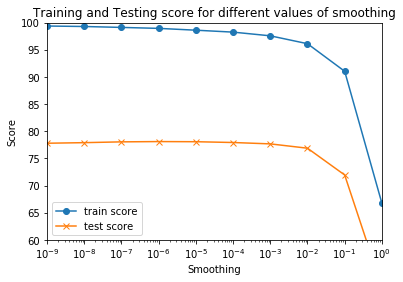

In [41]:
def plot_accuracy_vs_alpha(alphas, Train_score, Test_score):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xscale("log")
    ax.plot(alphas, Train_score, 'o-', label="train score")
    ax.plot(alphas, Test_score, 'x-', label="test score")
    pl.title('Training and Testing score for different values of smoothing')
    pl.xlabel('Smoothing')
    pl.ylabel('Score')
    plt.legend(loc='best')
    plt.ylim([60,100])
    plt.xlim([1e-9,1])
    pl.show() 
plot_accuracy_vs_alpha(alphas, Train_score, Test_score)

In [42]:
print("the best alpha value is (approximately) : ",alphas[np.argmax(Test_score)])

the best alpha value is (approximately) :  1e-06


Congratulations ! You have performed your first hyper-parameter optimization ! 

Now the need for a third independent set (a.k.a. the validation set) should be very clear to you.

## Multinomial classifier

see https://en.wikipedia.org/wiki/Multinomial_distribution for catching-up on maths.

same questions: (Copy-Paste is your friend, whis question may take you less than 5 min)
- train and test the SKlearn model with default parameters
- What are these default parameters ? What do they mean and what values were chosen / What choices were chosen ?
- What is the impact of smoothing ?

In [43]:
from sklearn.naive_bayes import MultinomialNB
Test_score = []
Train_score = []
alphas = [1., 0.5, 0.25, 0.1, 0.01, 0.001, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9] 
for al in alphas: 
    clf = MultinomialNB(alpha=al)
    clf.fit(X_train,y_train)
    Test_score.append(clf.score(X_test,y_test)*100)
    Train_score.append(clf.score(X_train,y_train)*100)
    print("alpha="+str(al), clf.score(X_test,y_test)*100, clf.score(X_train,y_train)*100)

alpha=1.0 77.44291024960171 91.31164928407283
alpha=0.5 78.75730217737653 93.71575039773732
alpha=0.25 79.96548061603823 95.68675976666078
alpha=0.1 81.09399893786511 97.3660951034117
alpha=0.01 82.43494423791822 99.56690825525897
alpha=0.001 82.4614976101965 99.84090507336045
alpha=0.0001 81.57195963887413 99.8585822874315
alpha=1e-05 80.82846521508232 99.8585822874315
alpha=1e-06 80.33722782793414 99.86742089446703
alpha=1e-07 79.97875730217737 99.86742089446703
alpha=1e-08 79.54062665958577 99.86742089446703
alpha=1e-09 79.0493892724376 99.86742089446703


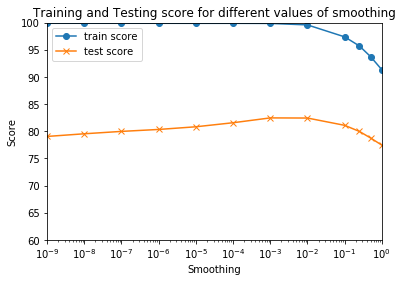

In [44]:
plot_accuracy_vs_alpha(alphas, Train_score, Test_score)

In [45]:
print("the best alpha value is (approximately) : ",alphas[np.argmax(Test_score)])

the best alpha value is (approximately) :  0.001


## Crucial point: did we "cheat" ?
- Visualize a couple more data examples, in particular take them all from the same class. Isn't there some piece  of information that we use here, and which looks a bit like "cheating" ?
- Now import data, again using *sklearn.datasets.fetch_20newsgroups()*, but with other values for the argument "remove". How do your classifiers (Bernoulli / Multionmial) change ? 
- Why ? What do you think of this ?

# ANSWER:

we cheated because we also read the headers and footers from the emails (the input data). From this, it is pretty easy to notice who talks about what, and just guess the answer (the topic of discussion) from the names of the people.



In [46]:
vectorizer_m = HashingVectorizer(stop_words='english',binary=False, norm=None, non_negative=True)
X_train_m = vectorizer_m.transform(data_train.data)
X_test_m = vectorizer_m.transform(data_test.data)

data_train = fetch_20newsgroups(subset='train', categories=categories, 
                                shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))

data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))

X_train = vectorizer.transform(data_train.data)
X_test = vectorizer.transform(data_test.data)

X_train_m = vectorizer_m.transform(data_train.data)
X_test_m = vectorizer_m.transform(data_test.data)

# test set
y_train, y_test = data_train.target, data_test.target

/home/flandes/miniconda2/lib/python2.7/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/home/flandes/miniconda2/lib/python2.7/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/home/flandes/miniconda2/lib/python2.7/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/home/flandes/miniconda2/lib/python2.7/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationW

In [47]:
print(data_train.data[0])

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


In [48]:
clfB = BernoulliNB(alpha=1e-6)
clfB.fit(X_train,y_train)
print("Bernoulli test and train scores:", clfB.score(X_test,y_test)*100, clfB.score(X_train,y_train)*100)
clfM = MultinomialNB(alpha=0.001)
clfM.fit(X_train_m,y_train)
print("Multinomial test and train scores:", clfM.score(X_test_m,y_test)*100, clfM.score(X_train_m,y_train)*100)

Bernoulli test and train scores: 58.404142326075416 88.88987095633728
Multinomial test and train scores: 64.48486457780137 90.86088032526074


## Think a bit about what you did

What did we do here ? How much did we build an AI ? In the image case, independence of the pixels had a very clear interpretation.  Here as well, the "Naive" assumption of independence has a very clear interpretation. What do you think of this assumption ? 

Do you think this kind of method would work for any serious NLP task ? (e.g. translation)

# ANSWER:

in short: no. This is what more complex models are about: combining the inputs linearly or non-linearly, so as to classfiy not just their values independently, but also how the input values are correlated.

Here we did the "Naive" (=independent input) version, so that things remain mathemtically simple, and so we can do things by hand.